I have recently been using facebook's timeseries prediction package [Prophet](https://facebookincubator.github.io/prophet/). Prophet add some much needed timeseries prediction power to python. It is simpler to use that [statsmodels](http://www.statsmodels.org/dev/tsa.html), the other major package in python for timeseries predictions, but this simplicity comes at a cost of obscuring what's going inside prophet. This post is my notes on understanding how Prophet works, and comes fom my own reading of the [Prophet source code](https://github.com/facebookincubator/prophet) and [accompanying paper](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf).

If you've read the documentation around the package, there isn't much new here, but hopefully it will be of use to someone.


## Introduction

Let's start by making a prediction with Prophet. We'll do this using [daily data from London's cycle hire scheme](https://data.london.gov.uk/dataset/number-bicycle-hires). We begin by loading this data

In [25]:
# load some libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

# load and clean the data
tfl = (
    pd.read_excel("tfl-daily-cycle-hires.xls", sheetname="Data")
    .rename(columns={"Day":"ds", "Number of Bicycle Hires": "y"})
    [["ds", "y"]]
    .copy()
)

tfl.ds = pd.to_datetime(tfl.ds)

tfl.head()

,ds,y
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


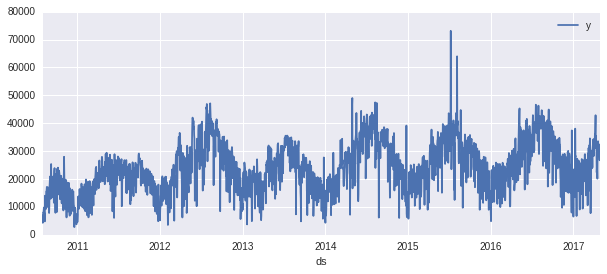

In [2]:
tfl.set_index("ds").plot(figsize=(10,4))

It is more or less what we would expect: yearly trends, weekly trends and a slow upwards growth, with lots of outliers along the way. 

We can now import the package:

In [3]:
import fbprophet

And, following the instructions in the [quickstart](https://facebookincubator.github.io/prophet/docs/quick_start.html), we can immediately fit a model to our data:

In [4]:
model = fbprophet.Prophet()
model.fit(tfl);

Prediction is also straight forward:

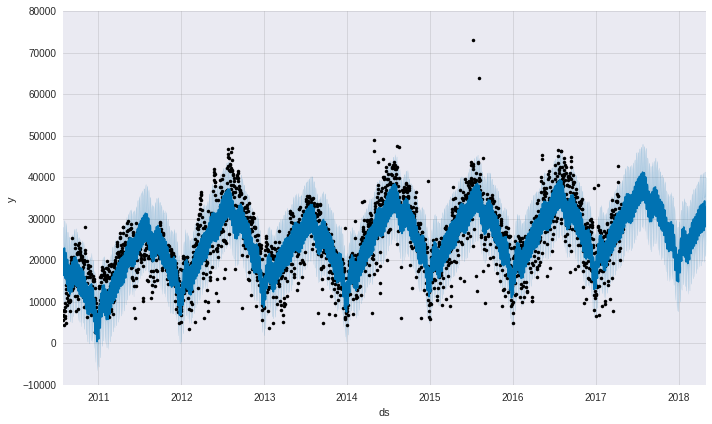

In [21]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
model.plot(forecast);

As well as predictions, we can quickly identify potential outliers:

In [23]:
# merge real points with forcast
real_and_forecast = pd.merge(left=forecast, right=tfl, on="ds")

# get the difference between prediction and forcast
real_and_forecast["residual"] = real_and_forecast.y - real_and_forecast.yhat

# get the range between 80% confidence intervals
real_and_forecast["uncertainty"] = real_and_forecast.yhat_upper - real_and_forecast.yhat_lower

# define an outlier as more than two intervals away from the forcast
v = 2
(
    real_and_forecast
    [real_and_forecast.residual.abs() > v * real_and_forecast.uncertainty]
    [["ds", "residual"]]
)

,ds,residual
1805,2015-07-09,35940.798939
1833,2015-08-06,26185.523156


Some quick googling suggests that the two points with an unusually large number of bike rentals happed on two days when there were tube strikes on: see [here](http://www.bbc.com/news/uk-england-london-33798637) and [here](http://www.itv.com/news/london/story/2015-07-09/strike-brings-londons-tube-network-to-a-standstill/). This suggests that potentially 35,000 extra people rented bikes as a result of a strike. It also gives us some idea of data we might want to include to make the predictions better.


And that is Prophet.

Let's see what's going on under the hood.

## How it works 

At it's heart, Prophet is fitting the following model to the data:

$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$

Where
 - $y(t)$ is the variable we are predicting
 - $g(t)$ is "growth/trend" - a slowly varying function
 - $s(t)$ is "seasonality" - periodic functions to take into account monthly/weekly patterns
 - $h(t)$ is "holiday" - takes into account the impact of "special" days that may not follow regular patterns
 - $\epsilon_t$ is the residuals, which are assumed to be i.i.d. and normally distributed 
 
Fitting to this function is carried out by [STAN](http://mc-stan.org/), a powerful statistical modeling package. A lot of my interest in understanding the insides of Prophet came from want to see STAN used in action.

## Components

We can directly look at the components which make up the forecast using the `plot_components` method

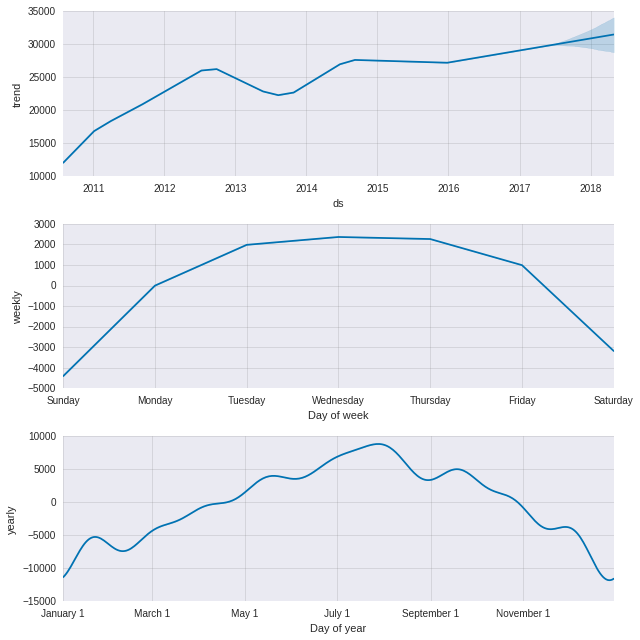

In [7]:
model.plot_components(forecast);

## Setting up the dataframe

Before fitting the various components, the dataframe is prepared. This is done by the `setup_dataframe` method, which converts the dates into a numbers between 0 and 1 and the $y$ values into scaled values between 0 and 1.

In [8]:
prepared = model.setup_dataframe(tfl)
prepared.head()

,ds,y,t,y_scaled
0,2010-07-30,6897,0.000000,0.094358
1,2010-07-31,5564,0.000406,0.076121
2,2010-08-01,4303,0.000811,0.058869
3,2010-08-02,6642,0.001217,0.090869
4,2010-08-03,7966,0.001622,0.108983


In [9]:
prepared.y_scaled.describe()

count    2467.000000
mean        0.333190
std         0.122545
min         0.037814
25%         0.248810
50%         0.327824
75%         0.418078
max         1.000000
Name: y_scaled, dtype: float64

### Trend
The growth/trend function $g(t)$ can either be modeled as linear or logistic function. In what follows, I'm going to explain the linear how the linear growth is formed. The logistic growth follows almost the same pattern.

When we initialised the model, the type of growth function defaulted to linear. However, if you look at the trend component of the forecast above, you notice that the trend is not just one linear component, but a sequence of piecewise linear components chained together. If prior information about when these changepoints might occur is available, the user can specify them. If not, prophet by default assumes that there are 25 evenly spaced changepoints spread over the first 80% of the data, and tried to choose their size optimally.

We can visualise them directly:

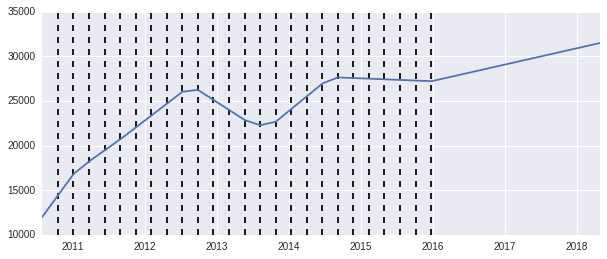

In [26]:
plt.figure(figsize=(10,4))

x = forecast.ds.values
y = forecast.trend.values
cp = model.changepoints

plt.plot(x,y)
ymin, ymax = plt.ylim()
plt.vlines(cp.values, ymin, ymax, linestyles="dashed")

You'll notice that while there are 25 change point, they do not always change the trend line. This comes from placing a sparse prior on the induced change.

Mathematically, the linear trend component is described by

$g(t) =(k + \sum_{i} a_{ti} \delta_{i}) \times t + (b + \sum_{i} a_{ti} \gamma_{i})$

Where 
 - $a$ is a matrix of shape |T| x |S| (where $T$ is the set of times we are training on and $S$ is a set of changepoints). 
 - $\mathbf{\delta}^{T} = (\delta_{0} \, \delta_{1} \, \delta_{2} \dots)$, a vector of trend changes. Each $\delta_{i}$ is the change of the trend at changepoint $i$, these are parameters we fit.
 - $\gamma$ is a vector whose value for component $i$ is $- \delta_{i} t_{i}$, where $s_{i}$ is the time of checkpoint $i$. This correction to the offset ensures that the trend is continuous.
 
We can check the value for $a$ that the model uses:

In [11]:
model.get_changepoint_matrix()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

The values of $\delta$ used come from fitting our model. In fitting, a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) is used as a prior. The scale parameter of this prior can be adjusted by setting the `changepoint_prior_scale` parameter on the constructor. This prior is equivalent to [$L_{1}$ regularisation](https://en.wikipedia.org/wiki/Lasso_(statistics).

# Seasonality

Seasonality refers to patterns in the data which repeat periodically. For timeseries measured on a daily level over years, we often see seasonality on the scale of weeks and years. Prophet attempts to models this by including weighted terms with the expected periodicity. Currently, Prophet only supports weekly and yearly seasonality.

The periodic components used are the lowest $n$ components of the [fourier series](http://mathworld.wolfram.com/FourierSeries.html) associated with a periodicity. We can look at a few of these components below

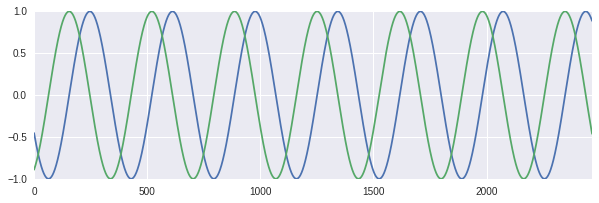

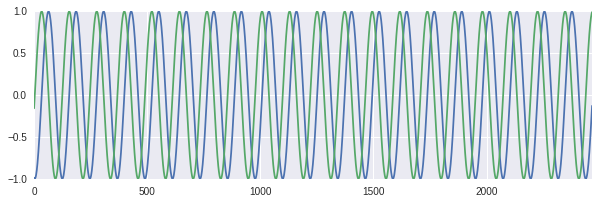

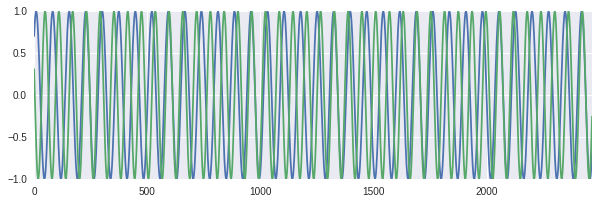

In [12]:
# plot individual components
seasons = model.make_all_seasonality_features(tfl)

seasons.yearly_delim_1.plot(figsize=(10,3))
seasons.yearly_delim_2.plot(figsize=(10,3))
plt.show()

seasons.yearly_delim_5.plot(figsize=(10,3))
seasons.yearly_delim_6.plot(figsize=(10,3))
plt.show()

seasons.yearly_delim_10.plot(figsize=(10,3))
seasons.yearly_delim_11.plot(figsize=(10,3))
plt.show()

Mathematically, we write the seasonality components as:

$s(t) = \sum_{i} \beta_{t} X_{i, t}$

Where
 - $\beta_{i}$ are the weighting of each term, which we will fit
 - $X_{i}$ are the time series associated with component $i$
 
And the $\beta_{i}$ terms are fitted with a normal prior, which is equivalent to [$L_{2}$ regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization). The width can be adjusted with the parameter `seasonality_prior_scale` in the models constructor.

We can take a look at the output of a subset of fitted seasonsal components with the following

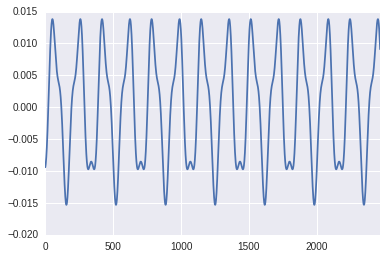

In [13]:
subset = [4,10]
beta = np.array(model.params["beta"])[0]

(beta[subset] * seasons[seasons.columns[subset]]).sum(axis=1).plot()

# Holidays 

In time series, there are often days which fall outside the regular pattern of trend and seasonality due to holidays or other large scale events. For example, let's see what happens to bike rentals around the end of December 2015:

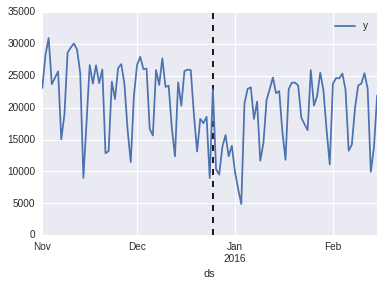

In [14]:
tfl.set_index("ds").ix["2015-11-01":"2016-02-15"].plot()
plt.vlines("2015-12-25", 0, 35000, linestyle="dashed")

The days around Christmas and new years have much lower rental rates than the weeks surrounding it. Interestingly given this decrease, Christmas day (the dashed line) has a higher rental rate then we would expect. We can find similar patterns 

To the effects of holidays into account, you can pass a list of holiday dates to Prophet's constructor:

In [15]:
holidays = pd.DataFrame({
    "holiday":"chirstmas",
    "ds": ["20" + str(i) + "-12-25" for i in range(11,17)],
    "lower_window":-1,
    "upper_window":2
})

holidays

,ds,holiday,lower_window,upper_window
0,2011-12-25,chirstmas,-1,2
1,2012-12-25,chirstmas,-1,2
2,2013-12-25,chirstmas,-1,2
3,2014-12-25,chirstmas,-1,2
4,2015-12-25,chirstmas,-1,2
5,2016-12-25,chirstmas,-1,2


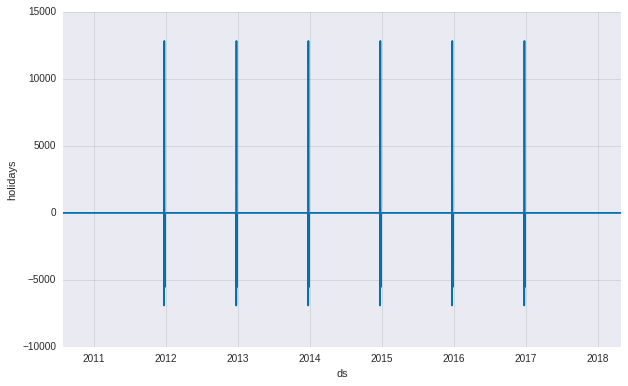

In [16]:
# we fit as before
model_with_holidays = fbprophet.Prophet(holidays=holidays)
model_with_holidays.fit(tfl)

# and predict
forecast_with_holiday = model_with_holidays.predict(future)

# and look can examine the holiday components
model_with_holidays.plot_holidays(forecast_with_holiday);

When you pass Prophet holiday dates, it takes them into account in a very similar way to seasonality: each holiday is assigned a parameter $\kappa_{i}$, which is used as a weight for an identity vector $Z$ which is 1 on all days the holiday falls, and 0 on all other days. In fact, for the purposes of predicting and fitting, holiday components are combined seasonal components.

The total holiday component is the described by

$h(t) = \sum_{i} \kappa_{i} Z_{t,i}$

This model assumes that the effects of the holidays are independent of each other.

And the $\kappa_{i}$ terms are fitted with a normal prior, whose width can be adjusted with the parameter `holidays_prior_scale` in the models constructor.

# Fitting Parameters 

All parameters of the model are fitted using STAN. [There](https://rpubs.com/pviefers/CologneR) are already [very good](https://www.youtube.com/watch?v=T1gYvX5c2sM) introductions to what STAN is and how it works, so I won't go into too much detail here.

The STAN code itself is particularly easy to read, so I'm going to reproduce the code here. For example, [the following code](https://github.com/facebookincubator/prophet/blob/master/python/stan/unix/prophet_linear_growth.stan) is used to fit a model with linear trend:

```
data {
  int T;                                // Sample size
  int<lower=1> K;                       // Number of seasonal vectors
  vector[T] t;                            // Day
  vector[T] y;                            // Time-series
  int S;                                // Number of changepoints
  matrix[T, S] A;                   // Split indicators
  real t_change[S];                 // Index of changepoints
  matrix[T,K] X;                // season vectors
  real<lower=0> sigma;              // scale on seasonality prior
  real<lower=0> tau;                  // scale on changepoints prior
}

parameters {
  real k;                            // Base growth rate
  real m;                            // offset
  vector[S] delta;                       // Rate adjustments
  real<lower=0> sigma_obs;               // Observation noise (incl. seasonal variation)
  vector[K] beta;                    // seasonal vector
}

transformed parameters {
  vector[S] gamma;                  // adjusted offsets, for piecewise continuity

  for (i in 1:S) {
    gamma[i] = -t_change[i] * delta[i];
  }
}

model {
  //priors
  k ~ normal(0, 5);
  m ~ normal(0, 5);
  delta ~ double_exponential(0, tau);
  sigma_obs ~ normal(0, 0.5);
  beta ~ normal(0, sigma);

  // Likelihood
  y ~ normal((k + A * delta) .* t + (m + A * gamma) + X * beta, sigma_obs);
}
```

The code blocks in the above can be interpreted in the following way:
 - `data{...}` defines the input to the model that we provide as users. 
 - `parameters{...}` defines the parameters which are to be fitted by the model
 - `transformed parameters{...}` defines any transformed parameters which are to be used
 - `model{...}` defines the probabilistic model that is to be fitted by STAN.
 
The addative model that underlies Prophet is defined in the second to last line:

```
  y ~ normal((k + A * delta) .* t + (m + A * gamma) + X * beta, sigma_obs);
```

Which tells us that we expect our timeseries, $y$, to follow the additive model up to normally distributed error terms. The rest of the STAN text is just setting things up for this.

# Calling .fit()

When we call the `.fit(df)` method, Prophet creates and formats the various pieces of data required for the model, and the calls `optimizing` on pySTAN. Once called, pySTAN attempts to fit the parameter values which estimate the posterior distribution defined by the model. 

By setting the constructor argument `mcmc_samples` to a non-zero value, the fitting process will return not just the optimal value for each of the parameters, but also full a MCMC approximation of the posterior. This will make the fitting process take longer.


It is straightforward to view the parameters fitted by the model

In [28]:
model.params

{'beta': array([[ 0.        , -0.02789544, -0.09795023,  0.0032827 , -0.01191055,
         -0.00079181, -0.01053872,  0.00922425, -0.00067823, -0.00432156,
         -0.0033903 ,  0.00964615, -0.00980707,  0.00425593, -0.00587887,
          0.00095963, -0.00622742,  0.00722454, -0.00857349,  0.00143998,
         -0.00183064, -0.03130348,  0.03356159,  0.01697193, -0.00058229,
         -0.00331231, -0.00206514]]),
 'delta': array([[ -6.28393636e-04,  -4.18861965e-01,  -7.86392209e-02,
          -2.92435593e-08,   4.56688711e-02,   2.57600035e-07,
          -1.52769503e-08,  -2.63458486e-07,  -4.79167582e-01,
          -5.73366291e-01,  -1.33463203e-07,   4.65374113e-07,
           2.31001984e-01,   4.15488010e-01,   4.45814979e-01,
           2.03386100e-08,  -7.04230890e-08,  -3.18685970e-01,
          -3.23622173e-01,   5.80621068e-08,   2.88568473e-07,
          -7.07708104e-09,   1.61374105e-07,   2.07247415e-05,
           1.99941271e-01]]),
 'gamma': array([[  2.01310208e-05,   2.6

# Making a Prediction 

We can now proceed to our goal: predicting the future.

When you call Prophet's `predict` method on a dataframe of dates, it extrapolates the trend and seasonality components which were previously fitted, and uses them to make predictions using the same additive model we've been working with up to this point. 

Behind the scenes Prophet calls three submethods: `predict_trend`, `predict_seasonal_components` and `predict_uncertainty` to achieve this. The first two of these work as you would expect: they extract the parameters obtained by fitting in the previous section, and project them forward in time. 

The `predict_uncertainty` component requires some more discussion. To understand what's going on, we note that there are a few different sources in uncertainty in our output model:

 - Normally distributed noise on the model
 - Uncertainty in our fitted parameters
 - Uncertainty in future trends

The first of these is given by the parameter `sigma_obs` gives us a measure of the uncertainty related to our prediction once seasonal and trend components have been take into account. 

To take into account our uncertainty in parameter values, it is possible to enable MCMC sampling as discussed above. In this case STAN will return samples from the posterior distribution defined by our additive model. When these samples are used to project the components forward, they give us an estimate of the distribution of outcomes, allowing us to estimate the uncertainty. If MCMC sampling is not enabled, the model will use the single values returned.

To take into account the uncertainty in the trend component, many "potential" trends can simulated. This is carried out in the `sample_predictive_trend` method. To do this, it is assumed that for the prediction period there are changepoints with Laplace distributed sizes and uniform random spacing. By simulating many of these possible trends, the uncertainty of the model is approximated. 

We can get an example of a few of these simulated trends using the code below

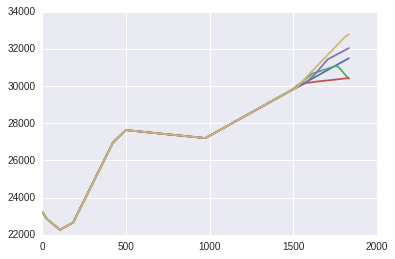

In [31]:
df = model.setup_dataframe(future)

pred_trend = [model.sample_predictive_trend(df, 0) for _ in range(5)]

for i in pred_trend:
    plt.plot(i[1000:])

# Conclusion

That's all there is to Prophet. When you dig into it, it's surprising how simple the ideas behind it are. However the combination of this simplicity and robust packaging, together with STAN's sampling abilities result in a very powerful library for fast time series forecasting.

## Code
You can find the notebook for this post on github [here]().